In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /tmp/horse-or-human.zip

/tmp/horse-or-human.zip: Permission denied


The following python code will use the OS library to use Operating System libraries, giving you access to the file system, and the zipfile library allowing you to unzip the data. 

下面的python代码将使用OS库来调用文件系统，并使用zipfile库来解压数据。

In [5]:
import os
import zipfile

local_zip = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/horse-or-human')
zip_ref.close()

The contents of the .zip are extracted to the base directory `/tmp/horse-or-human`, which in turn each contain `horses` and `humans` subdirectories.

In short: The training set is the data that is used to tell the neural network model that 'this is what a horse looks like', 'this is what a human looks like' etc. 

One thing to pay attention to in this sample: We do not explicitly label the images as horses or humans. If you remember with the handwriting example earlier, we had labelled 'this is a 1', 'this is a 7' etc.  Later you'll see something called an ImageGenerator being used -- and this is coded to read images from subdirectories, and automatically label them from the name of that subdirectory. So, for example, you will have a 'training' directory containing a 'horses' directory and a 'humans' one. ImageGenerator will label the images appropriately for you, reducing a coding step. 

Let's define each of these directories:

Zip文件的内容会被解压到目录`/tmp/horse-or-human`，而该目录下又分别包含`horses`和`humans`子目录。

简而言之：训练集就是用来告诉神经网络模型 "这就是马的样子"、"这就是人的样子 "等数据。

这里需要注意的是，我们并没有明确地将图像标注为马或人。如果还记得之前的手写数字例子，它的训练数据已经标注了 "这是一个1"，"这是一个7 "等等。 稍后，我们使用一个叫做ImageGenerator的类--用它从子目录中读取图像，并根据子目录的名称自动给图像贴上标签。所以，会有一个 "训练 "目录，其中包含一个 "马匹 "目录和一个 "人类 "目录。ImageGenerator将为你适当地标注图片，从而减少一个编码步骤。（不仅编程上更方便，而且可以避免一次性把所有训练数据载入内存，而导致内存不够等问题。）

让我们分别定义这些目录。

In [6]:
# Directory with our training horse pictures
train_horse_dir = os.path.join('/tmp/horse-or-human/horses')

# Directory with our training human pictures
train_human_dir = os.path.join('/tmp/horse-or-human/humans')

Now, let's see what the filenames look like in the `horses` and `humans` training directories:

现在，让我们看看 "马 "和 "人 "训练目录中的文件名是什么样的。

In [4]:
train_horse_names = os.listdir(train_horse_dir)
print(train_horse_names[:10])

train_human_names = os.listdir(train_human_dir)
print(train_human_names[:10])

['horse39-1.png', 'horse47-6.png', 'horse12-1.png', 'horse23-7.png', 'horse11-0.png', 'horse50-8.png', 'horse38-5.png', 'horse42-3.png', 'horse29-5.png', 'horse36-6.png']
['human09-00.png', 'human09-14.png', 'human11-11.png', 'human04-14.png', 'human14-14.png', 'human07-03.png', 'human06-04.png', 'human09-29.png', 'human08-03.png', 'human14-16.png']


Let's find out the total number of horse and human images in the directories:

我们来看看目录中马和人的图片总数。

In [6]:
print('total training horse images:', len(os.listdir(train_horse_dir)))
print('total training human images:', len(os.listdir(train_human_dir)))

total training horse images: 500
total training human images: 527


Now let's take a look at a few pictures to get a better sense of what they look like. First, configure the matplot parameters:

现在我们来看看几张图片，以便对它们的样子有个直观感受。首先，配置matplot参数。

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

Now, display a batch of 8 horse and 8 human pictures. You can rerun the cell to see a fresh batch each time:

接下来，显示一批8张马和8张人的图片。每次重新运行单元格，都会看到一个新的批次（另外8张马和8张人）。

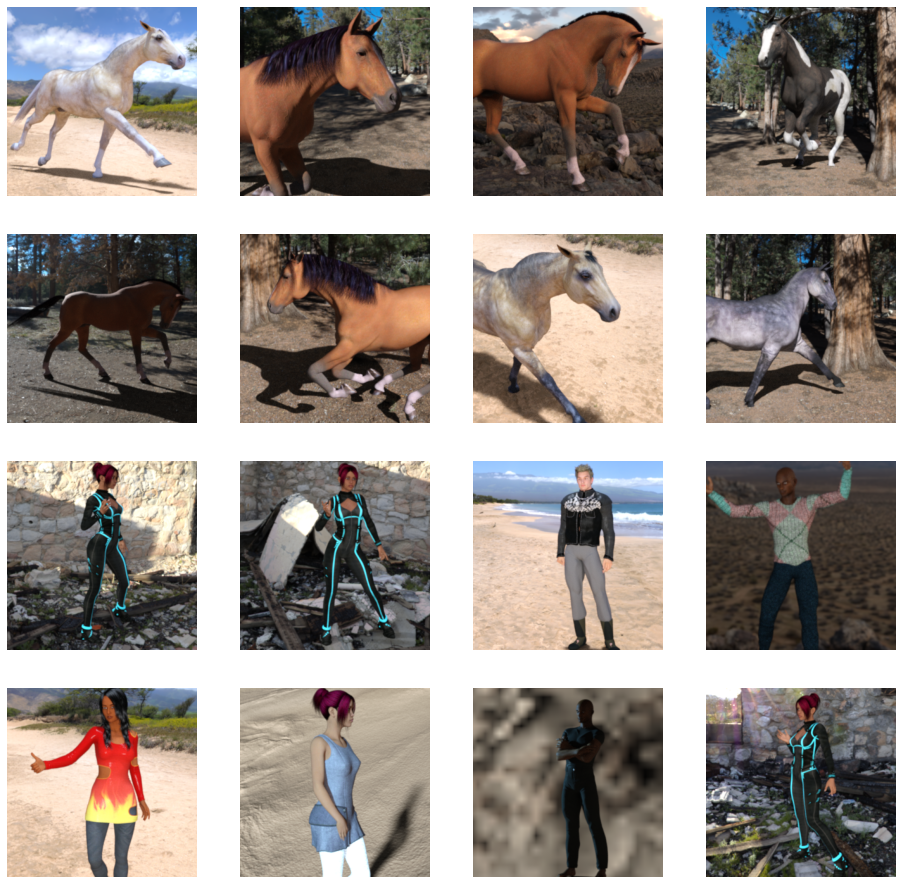

In [8]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_horse_pix = [os.path.join(train_horse_dir, fname) 
                for fname in train_horse_names[pic_index-8:pic_index]]
next_human_pix = [os.path.join(train_human_dir, fname) 
                for fname in train_human_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_horse_pix+next_human_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


## Building a Small Model from Scratch

But before we continue, let's start defining the model:

Step 1 will be to import tensorflow.

## 从零开始建立一个小型模型

让我们开始定义模型：

第一步是导入 tensorflow.

In [1]:
import tensorflow as tf

We then add convolutional layers as in the previous example, and flatten the final result to feed into the densely connected layers.

然后，像前面的例子一样添加卷积层，并将最终结果扁平化，以输送到全连接的层去。

Finally we add the densely connected layers. 

Note that because we are facing a two-class classification problem, i.e. a *binary classification problem*, we will end our network with a [*sigmoid* activation](https://wikipedia.org/wiki/Sigmoid_function), so that the output of our network will be a single scalar between 0 and 1, encoding the probability that the current image is class 1 (as opposed to class 0).

最后我们添加全连接层。

需要注意的是，由于我们面对的是一个两类分类问题，即*二类分类问题*，所以我们会用[*sigmoid*激活函数](https://wikipedia.org/wiki/Sigmoid_function)作为模型的最后一层，这样我们网络的输出将是一个介于0和1之间的有理数，即当前图像是1类（而不是0类）的概率。

In [2]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

The model.summary() method call prints a summary of the NN 

调用model.summary()方法打印出神经元网络模型的结构信息

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        3

The "output shape" column shows how the size of your feature map evolves in each successive layer. The convolution layers reduce the size of the feature maps by a bit due to padding, and each pooling layer halves the dimensions.

"输出形状 "一栏显示了特征图尺寸在每个层中是如何演变的。卷积层由于边框关系而使特征图的尺寸减小了一些，而每个池化层则将输出尺寸减半。

Next, we'll configure the specifications for model training. We will train our model with the `binary_crossentropy` loss, because it's a binary classification problem and our final activation is a sigmoid. (For a refresher on loss metrics, see the [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/descending-into-ml/video-lecture).) We will use the `rmsprop` optimizer with a learning rate of `0.001`. During training, we will want to monitor classification accuracy.

**NOTE**: In this case, using the [RMSprop optimization algorithm](https://wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) is preferable to [stochastic gradient descent](https://developers.google.com/machine-learning/glossary/#SGD) (SGD), because RMSprop automates learning-rate tuning for us. (Other optimizers, such as [Adam](https://wikipedia.org/wiki/Stochastic_gradient_descent#Adam) and [Adagrad](https://developers.google.com/machine-learning/glossary/#AdaGrad), also automatically adapt the learning rate during training, and would work equally well here.)

接下来，我们将配置模型训练的参数。我们将用 "binary_crossentropy（二元交叉熵）"衡量损失，因为这是一个二元分类问题，最终的激活函数是一个sigmoid。关于损失度量的复习，请参见[机器学习速成班](https://developers.google.com/machine-learning/crash-course/descending-into-ml/video-lecture)。我们将使用`rmsprop`作为优化器，学习率为`0.001`。在训练过程中，我们将希望监控分类精度。

**NOTE**.我们将使用学习率为`0.001`的`rmsprop`优化器。在这种情况下，使用[RMSprop优化算法](https://wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp)比[随机梯度下降](https://developers.google.com/machine-learning/glossary/#SGD)(SGD)更可取，因为RMSprop可以为我们自动调整学习率。(其他优化器，如[Adam](https://wikipedia.org/wiki/Stochastic_gradient_descent#Adam)和[Adagrad](https://developers.google.com/machine-learning/glossary/#AdaGrad)，也会在训练过程中自动调整学习率，在这里也同样有效。)

In [3]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

### Data Preprocessing

Let's set up data generators that will read pictures in our source folders, convert them to `float32` tensors, and feed them (with their labels) to our network. We'll have one generator for the training images and one for the validation images. Our generators will yield batches of images of size 300x300 and their labels (binary).

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network. (It is uncommon to feed raw pixels into a convnet.) In our case, we will preprocess our images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).

In Keras this can be done via the `keras.preprocessing.image.ImageDataGenerator` class using the `rescale` parameter. This `ImageDataGenerator` class allows you to instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`. These generators can then be used with the Keras model methods that accept data generators as inputs: `fit_generator`, `evaluate_generator`, and `predict_generator`.

### 数据预处理

让我们设置训练数据生成器（ImageDataGenerator），它将读取源文件夹中的图片，将它们转换为`float32`多维数组，并将图像数据（连同它们的标签）反馈给神经元网络。总共需要两个生成器，有用于产生训练图像，一个用于产生验证图像。生成器将产生一批大小为300x300的图像及其标签（0或1）。

前面的课中我们已经知道如何对训练数据做归一化，进入神经网络的数据通常应该以某种方式进行归一化，以使其更容易被网络处理。在这个例子中，我们将通过将像素值归一化到`[0, 1]`范围内（最初所有的值都在`[0, 255]`范围内）来对图像进行预处理。

在Keras中，可以通过`keras.preprocessing.image.ImageDataGenerator`类使用`rescale`参数来实现归一化。通过`ImageDataGenerator`类的`.flow(data, labels)`或`.flow_from_directory(directory)`，可以创建生成器。然后，这些生成器可以作为输入Keras方法的参数，如`fit_generator`、`evaluate_generator`和`predict_generator`都可接收生成器实例为参数。

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/tmp/horse-or-human/',  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=32, #128
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')


Found 1027 images belonging to 2 classes.


### Training
Let's train for 15 epochs -- this may take a few minutes to run.

Do note the values per epoch.

The Loss and Accuracy are a great indication of progress of training. It's making a guess as to the classification of the training data, and then measuring it against the known label, calculating the result. Accuracy is the portion of correct guesses. 

###训练
让我们训练15个epochs--这可能需要几分钟的时间完成运行。

请注意每次训练后的数值。

损失和准确率是训练进展的重要指标。模型对训练数据的类别进行预测，然后根据已知标签进行评估，计算准确率。准确率是指正确预测的比例。

In [8]:
history = model.fit(
      train_generator,
      steps_per_epoch=8,  
      epochs=15,
      verbose=1)

Epoch 1/15
8/8 [==============================] - 2s 277ms/step - loss: 0.6836 - acc: 0.5781
Epoch 2/15
8/8 [==============================] - 2s 279ms/step - loss: 0.6074 - acc: 0.7031
Epoch 3/15
8/8 [==============================] - 2s 272ms/step - loss: 0.3751 - acc: 0.8555
Epoch 4/15
8/8 [==============================] - 2s 264ms/step - loss: 0.7221 - acc: 0.8722
Epoch 5/15
8/8 [==============================] - 2s 266ms/step - loss: 0.2367 - acc: 0.9023
Epoch 6/15
8/8 [==============================] - 2s 231ms/step - loss: 0.1246 - acc: 0.9559
Epoch 7/15
8/8 [==============================] - 2s 264ms/step - loss: 0.1748 - acc: 0.9414
Epoch 8/15
8/8 [==============================] - 2s 274ms/step - loss: 0.1481 - acc: 0.9414
Epoch 9/15
8/8 [==============================] - 2s 287ms/step - loss: 0.2387 - acc: 0.9163
Epoch 10/15
8/8 [==============================] - 2s 258ms/step - loss: 0.1319 - acc: 0.9648
Epoch 11/15
8/8 [==============================] - 2s 267ms/step - lo

### Running the Model

Let's now take a look at actually running a prediction using the model. This code will allow you to choose 1 or more files from your file system, it will then upload them, and run them through the model, giving an indication of whether the object is a horse or a human.

###运行模型

接下来，看看使用模型进行实际预测。这段代码将允许你从文件系统中选择1个或多个文件，然后它将上传它们，并通过模型判断给出图像是马还是人。

In [1]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(300, 300))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a human")
  else:
    print(fn + " is a horse")
 

/opt/tljh/user/lib/python3.7/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


KeyboardInterrupt: 

### Visualizing Intermediate Representations

To get a feel for what kind of features our convnet has learned, one fun thing to do is to visualize how an input gets transformed as it goes through the convnet.

Let's pick a random image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map. Rerun this cell to generate intermediate representations for a variety of training images.

### 将中间层的输出可视化

要想了解 convnet（卷积层）学到了什么样的特征，一个有趣的办法是将模型每个卷积层的输出当作图像可视化。

让我们从训练集中随机选取一张图像，然后将每一层的输出排列在一行里，生成一个汇总图。行中的每张图像都是一个特定过滤器输出的特征。每次运行下面这个单元的代码，就会随机显示一张图像的中间输出结果。

In [9]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
# Let's prepare a random input image from the training set.
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)

img = load_img(img_path, target_size=(300, 300))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

NameError: name 'train_horse_names' is not defined

As you can see we go from the raw pixels of the images to increasingly abstract and compact representations. The representations downstream start highlighting what the network pays attention to, and they show fewer and fewer features being "activated"; most are set to zero. This is called "sparsity." Representation sparsity is a key feature of deep learning.


These representations carry increasingly less information about the original pixels of the image, but increasingly refined information about the class of the image. You can think of a convnet (or a deep network in general) as an information distillation pipeline.

从上面结果可以看出，图像每通过模型的一层，像素特征变得越来越抽象和紧凑。逐渐地，表征开始突出网络所关注的内容，它们显示出越来越少的像素被 "激活"；大多数被设置为零。这就是所谓的 "稀疏性"。表征稀疏性是深度学习的一个关键特征。

这些表征携带的图像原始像素的信息越来越少，但关于图像类别的信息却越来越精细。你可以把一个convnet（或一般的深度网络）看作是一个信息提炼管道。

## Clean Up

Before running the next exercise, run the following cell to terminate the kernel and free memory resources:

运行以下单元格可以终止内核并释放内存资源。当计算资源不够时需要进行释放。

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)

## 调参
构造神经元网络模型时，一定会考虑需要几个卷积层？过滤器应该几个？全连接层需要几个神经元？

最先想到的肯定是手动修改那些参数，然后观察训练的效果（损失和准确度），从而判断参数的设置是否合理。但是那样很繁琐，因为参数组合会有很多，训练时间很长。再进一步，可以手动编写一些循环，通过遍历来搜索合适的参数。但是最好利用专门的框架来搜索参数，不太容易出错，效果也比前两种方法更好。

Kerastuner就是一个可以自动搜索模型训练参数的库。它的基本思路是在需要调整参数的地方插入一个特殊的对象（可指定参数范围），然后调用类似训练那样的search方法即可。

接下来首先准备训练数据和需要加载的库。

In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)
train_generator = train_datagen.flow_from_directory('/tmp/horse-or-human/',  
        target_size=(150, 150),batch_size=32,class_mode='binary')
validation_generator = validation_datagen.flow_from_directory('/tmp/validation-horse-or-human/',  
        target_size=(150, 150), batch_size=32,class_mode='binary')
from kerastuner.tuners import Hyperband
from kerastuner.engine.hyperparameters import HyperParameters
import tensorflow as tf


接着创建HyperParameters对象，然后在模型中插入Choice、Int等调参用的对象。

In [ ]:
hp=HyperParameters()
def build_model(hp):
    model = tf.keras.models.Sequential()        
    model.add(tf.keras.layers.Conv2D(hp.Choice('num_filters_top_layer',values=[16,64],default=16), (3,3), 
                                     activation='relu', input_shape=(150, 150, 3)))
    model.add(tf.keras.layers.MaxPooling2D(2, 2))
    for i in range(hp.Int("num_conv_layers",1,3)):
        model.add(tf.keras.layers.Conv2D(hp.Choice(f'num_filters_layer{i}',values=[16,64],default=16), (3,3), activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D(2,2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(hp.Int("hidden_units",128,512,step=32), activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer=RMSprop(lr=0.001),metrics=['acc'])
    return model


然后创建Hyperband对象，这是Kerastuner支持的四种方法的其中一种，其优点是能较四童话第查找参数。具体资料可以到Kerastuner的网站获取。

最后调用search方法。

In [ ]:
tuner=Hyperband(
    build_model,
    objective='val_acc',
    max_epochs=10,
    directory='horse_human_params',
    hyperparameters=hp,
    project_name='my_horse_human_project'
)
tuner.search(train_generator,epochs=10,validation_data=validation_generator)

搜索到最优参数后，可以通过下面的程序，用tuner对象提取最优参数构建神经元网络模型。并调用summary方法观察优化后的网络结构。

In [ ]:
best_hps=tuner.get_best_hyperparameters(1)[0]
print(best_hps.values)
model=tuner.hypermodel.build(best_hps)
model.summary()
